<a href="https://colab.research.google.com/github/leandrosbo/TelecomX/blob/main/TELECONX_2_ANALISE_EVASAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# telecom_churn_modelos.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# =======================
# 1. Carregar dados limpos
# =======================
# 1. Carregar dados e remover coluna de ID
df = pd.read_csv("TelecomX_Dados_Limpos.csv")
df = df.dropna()

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

X = df.drop("Churn", axis=1)
y = df["Churn"]

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# =======================
# 2. Dividir em treino e teste (80/20)
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =======================
# 3. Regressão Logística (com normalização e encoding)
# =======================
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("🔎 Regressão Logística:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# =======================
# 4. Random Forest (com encoding, sem normalização para RF)
# =======================
# For Random Forest, we only need encoding for categorical features
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("🌳 Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

🔎 Regressão Logística:
[[820 111]
 [134 206]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       931
           1       0.65      0.61      0.63       340

    accuracy                           0.81      1271
   macro avg       0.75      0.74      0.75      1271
weighted avg       0.80      0.81      0.81      1271

🌳 Random Forest:
[[833  98]
 [145 195]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       931
           1       0.67      0.57      0.62       340

    accuracy                           0.81      1271
   macro avg       0.76      0.73      0.74      1271
weighted avg       0.80      0.81      0.80      1271




Correlação com a variável Churn:
 Churn                                     1.000000
internet_InternetService_Fiber optic      0.308020
account_PaymentMethod_Electronic check    0.301919
account_Charges_Monthly                   0.193356
Contas_Diarias                            0.193356
account_PaperlessBilling                  0.191825
customer_SeniorCitizen                    0.150889
internet_StreamingTV_Yes                  0.063228
internet_StreamingMovies_Yes              0.061382
phone_MultipleLines                       0.040207
Name: Churn, dtype: float64
Análise concluída. Arquivo salvo como TelecomX_Dados_Limpos.csv


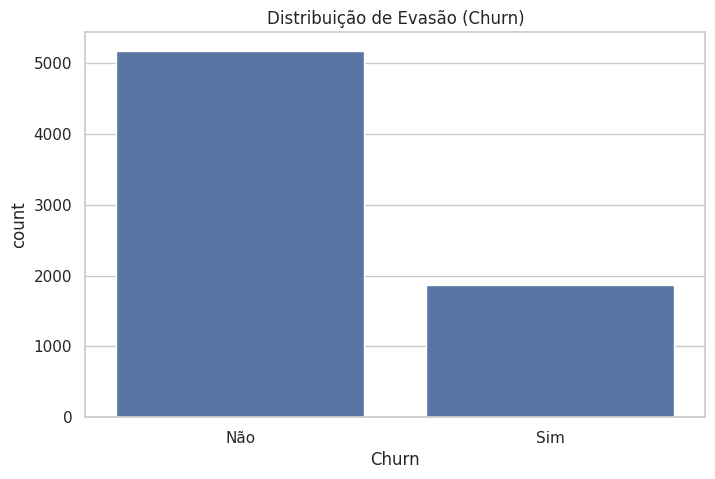

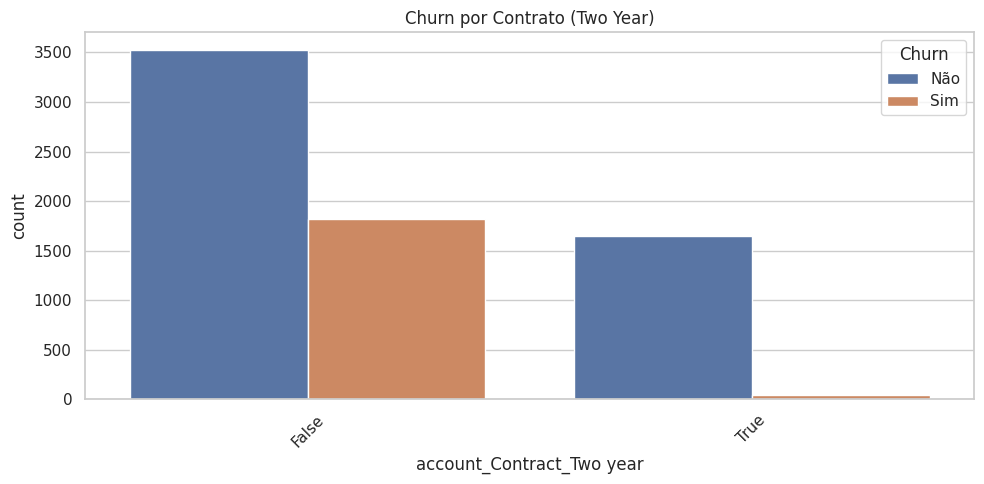

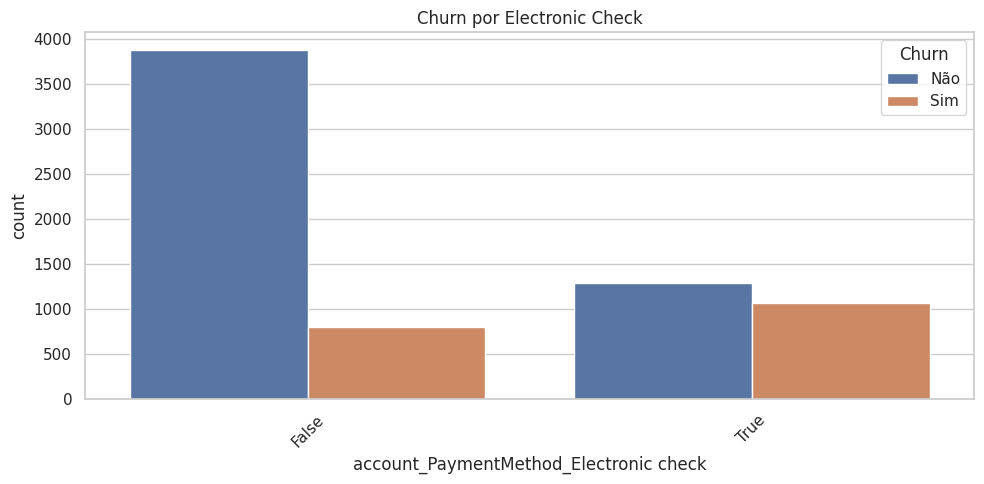

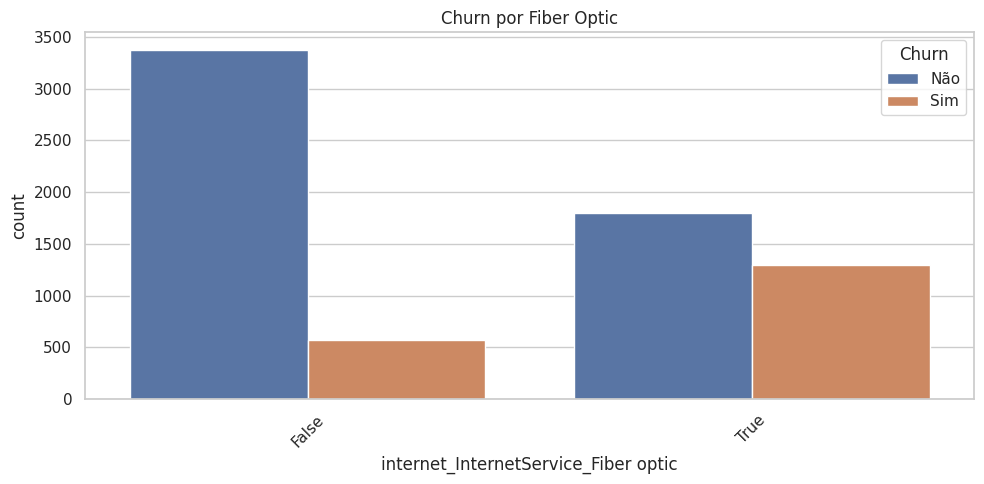

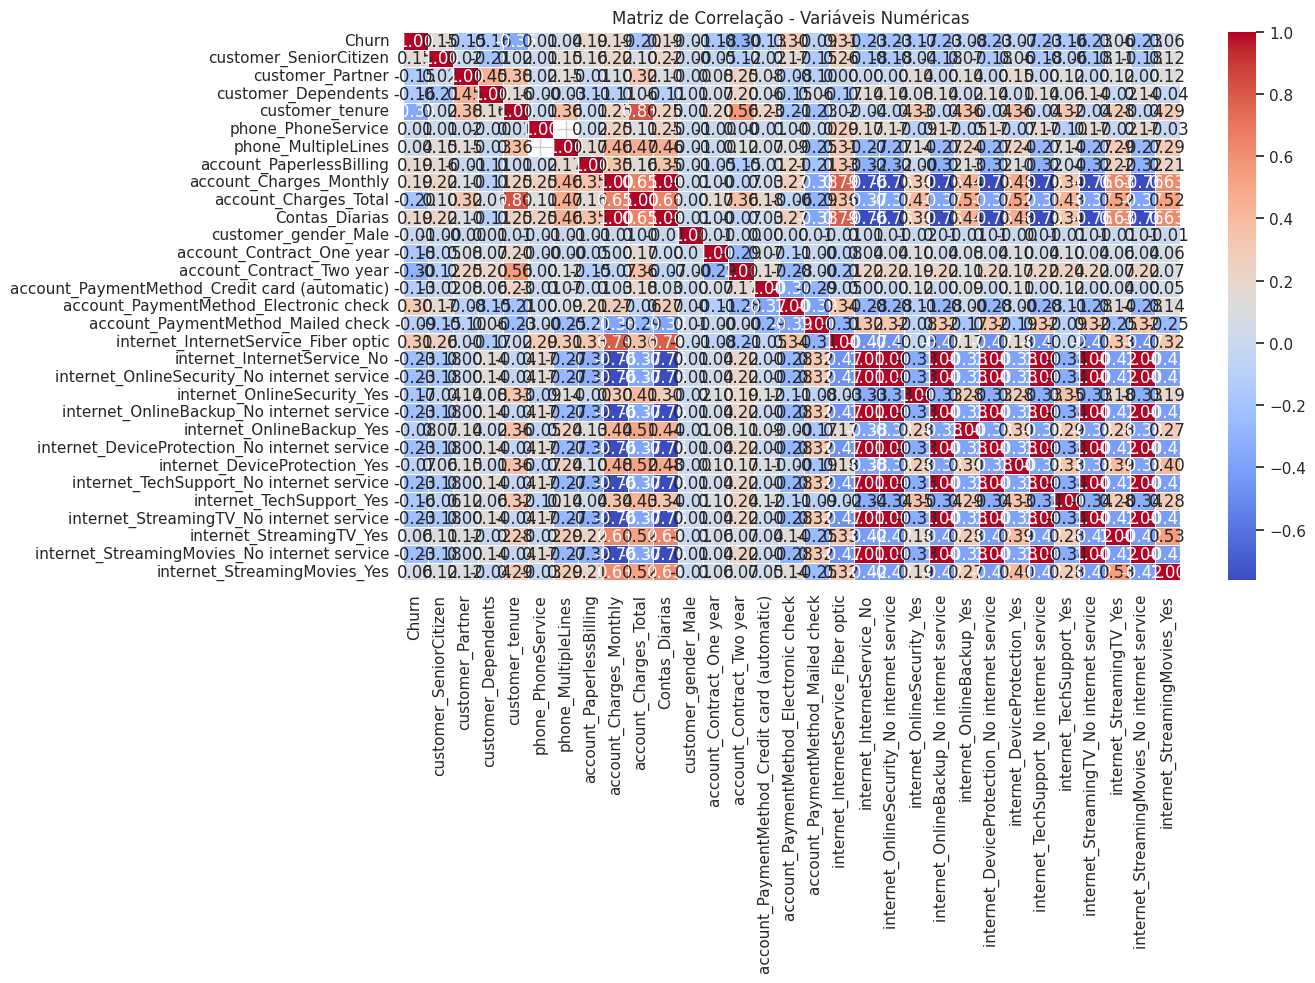

In [8]:

# telecom_churn_analysis.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# =======================
# 1. Carregamento dos Dados
# =======================
with open("/content/TelecomX_Data (1).json", "r") as file:
    raw_data = json.load(file)

df = pd.json_normalize(raw_data, sep="_")

# =======================
# 2. Limpeza e Transformação
# =======================
df["account_Charges_Monthly"] = pd.to_numeric(df["account_Charges_Monthly"], errors="coerce")
df["account_Charges_Total"] = pd.to_numeric(df["account_Charges_Total"], errors="coerce")
df["Contas_Diarias"] = df["account_Charges_Monthly"] / 30

df["Churn"] = df["Churn"].replace("", pd.NA)
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Binárias em 0 e 1
bin_cols = [
    "customer_Partner", "customer_Dependents", "phone_PhoneService",
    "phone_MultipleLines", "account_PaperlessBilling"
]
for col in bin_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

# Remover colunas irrelevantes
df = df.drop(columns=["customerID"])

# One-Hot Encoding para variáveis categóricas
categorical_cols = [
    "customer_gender",
    "account_Contract",
    "account_PaymentMethod",
    "internet_InternetService",
    "internet_OnlineSecurity",
    "internet_OnlineBackup",
    "internet_DeviceProtection",
    "internet_TechSupport",
    "internet_StreamingTV",
    "internet_StreamingMovies"
]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# =======================
# 3. Análise Exploratória
# =======================
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(x="Churn", data=df)
plt.title("Distribuição de Evasão (Churn)")
plt.xticks([0, 1], ["Não", "Sim"])
plt.savefig("grafico_churn.png")

# Gráficos categóricos
def churn_barplot(col, title, filename):
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue="Churn", data=df)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title="Churn", labels=["Não", "Sim"])
    plt.tight_layout()
    plt.savefig(filename)

churn_barplot("account_Contract_Two year", "Churn por Contrato (Two Year)", "churn_contrato.png")
churn_barplot("account_PaymentMethod_Electronic check", "Churn por Electronic Check", "churn_pagamento.png")
churn_barplot("internet_InternetService_Fiber optic", "Churn por Fiber Optic", "churn_internet.png")

# =======================
# 4. Matriz de Correlação
# =======================
plt.figure(figsize=(14, 10))
correlacao = df.corr(numeric_only=True)
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.tight_layout()
plt.savefig("matriz_correlacao.png")

# Correlação com churn
cor_churn = correlacao["Churn"].sort_values(ascending=False)
print("\nCorrelação com a variável Churn:\n", cor_churn.head(10))

# =======================
# 5. Exportação Final
# =======================
df.to_csv("TelecomX_Dados_Limpos.csv", index=False)
print("Análise concluída. Arquivo salvo como TelecomX_Dados_Limpos.csv")
